In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("goalkeeper_analytics").getOrCreate()

In [0]:
df = spark.read.csv(
   path='dbfs:/FileStore/tables/23_24_goalkeeping_stats',
   sep=',',
   header=True,
   inferSchema=True,
)

In [0]:
df1 = spark.read.csv(
   path='dbfs:/FileStore/tables/23_24_adv_goalkeeping_stats',
   sep=',',
   header=True,
   inferSchema=True,
)


### Data Transformation

In [0]:
cols = ['Player', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'GA90', 'Save%16', 'CS%']
df = (df.select(cols)
      .withColumnRenamed('Save%16', 'Save_percentage').withColumnRenamed('CS%', 'clean_sheet_percentage')
      .withColumn("Age", F.split(df['Age'], '-').getItem(0).cast(IntegerType()))
      .filter(F.col('mp') > 20))

In [0]:
cols_to_keep = ['Player', '/90', 'Stp%']
df1 = (df1.select(cols_to_keep)
       .withColumnRenamed('/90', 'post_shot_exp_goals')
       .withColumnRenamed('Stp%', 'crosses_stopped_percentage'))

In [0]:
df = df.join(df1, on='player', how='inner')
df.toDF(*[x.lower() for x in df.columns])

Out[6]: DataFrame[player: string, pos: string, squad: string, comp: string, age: int, born: int, mp: int, starts: int, ga90: double, save_percentage: double, clean_sheet_percentage: double, post_shot_exp_goals: double, crosses_stopped_percentage: double]

#### Weighting Factors

In [0]:
save_percentage_weight = 0.3
clean_sheet_percentage_weight = 0.25
goals_aganist_per_90_weight = 0.2
crosses_stopped_weight = 0.1
psxg_ga_per_90 = 0.15

In [0]:
windowSpec = Window.orderBy(F.desc("WeightedScore"))

df = (df.withColumn("WeightedScore", 
        (F.col('save_percentage') * save_percentage_weight) 
        + (F.col('clean_sheet_percentage') * clean_sheet_percentage_weight) 
        + (F.col('ga90') * goals_aganist_per_90_weight) 
        + (F.col('crosses_stopped_percentage') * crosses_stopped_weight) 
        + (F.col('post_shot_exp_goals') * psxg_ga_per_90))
      .withColumn("Rank", F.dense_rank().over(window=windowSpec)))

In [0]:
df.show(10)

+--------------------+---+-------------+-------------+---+----+---+------+----+---------------+----------------------+-------------------+--------------------------+------------------+----+
|              Player|Pos|        Squad|         Comp|Age|Born| MP|Starts|GA90|Save_percentage|clean_sheet_percentage|post_shot_exp_goals|crosses_stopped_percentage|     WeightedScore|Rank|
+--------------------+---+-------------+-------------+---+----+---+------+----+---------------+----------------------+-------------------+--------------------------+------------------+----+
|         Yann Sommer| GK|        Inter|   it Serie A| 35|1988| 28|    28| 0.5|           83.6|                  60.7|               0.17|                       4.5|           40.8305|   1|
|Vanja Milinković-...| GK|       Torino|   it Serie A| 27|1997| 28|    28|0.86|           81.5|                  50.0|               0.07|                       9.3|           38.0625|   2|
|        Marcin Bułka| GK|         Nice|   fr Ligu

#### Bar chart

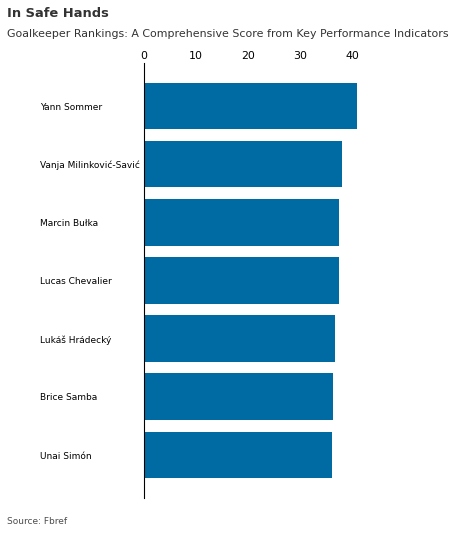

In [0]:
df_barh = df.orderBy(F.col("WeightedScore").desc()).limit(7).toPandas()

fig, ax = plt.subplots(figsize=(4,8))
ax.barh(df_barh['Player'], df_barh['WeightedScore'], color='#006BA2')
ax.invert_yaxis()
ax.spines[['top', 'right', 'bottom']].set_visible(False)
ax.spines['left'].set_linewidth(1.1)
ax.xaxis.set_tick_params(labeltop=True, labelbottom=False, bottom=False, labelsize=11, pad=-1)

y_ticks = range(len(df_barh['Player']))

ax.set_yticks(y_ticks) 
ax.set_yticklabels(df_barh['Player'], ha='left') 

ax.yaxis.set_tick_params(pad=100, labelsize=9, bottom=False)

ax.text(x=-.35, y=.96, s="In Safe Hands", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=-.35, y=.925, s="Goalkeeper Rankings: A Comprehensive Score from Key Performance Indicators", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

ax.text(x=-.35, y=.08, s="""Source: Fbref""", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.gcf().set_facecolor('white')